# 機会を持つ人

In [1]:
from rdflib import Graph

import io
import sys

sys.path.append('../src/')
from utils import *

In [2]:
knowledge_graph_dir = '../KnowledgeGraph/'
additional_knowledge_graph_dir = '../AdditionalKnowledgeGraph/'

In [3]:
g = Graph()
rdf_files = [
  f'{knowledge_graph_dir}/SpeckledBand_mod.ttl',
  f'{additional_knowledge_graph_dir}/holeClass.ttl',
  f'{additional_knowledge_graph_dir}/holeScene.ttl',
]
g = load_rdf_files(g, rdf_files)

In [4]:
print_scene = create_print_scene(g)

## 事件当時どこにいたのか

In [5]:
q = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#>
PREFIX kd: <http://kgc.knowledge-graph.jp/data/SpeckledBand/>

SELECT DISTINCT 
  ?scene 
  ?subject 
  ?location
WHERE{
  BIND(kd:67 as ?muder_scene) # 殺人のシーン
  ?muder_scene kgc:when ?the_time.
  
  ?subject a kgc:Person.
  
  ?scene kgc:when ?the_time;
         kgc:subject ?subject;
         kgc:where ?location.
         
  MINUS {
    ?muder_scene kgc:then+ ?scene.
  }
} 
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

,scene,subject,location
0,kd:67,kd:Helen,kd:bedroom_of_Helen
1,kd:107,kd:Roma,kd:garden_of_Roylott
2,kd:55,kd:Julia,kd:bedroom_of_Julia
3,kd:103,kd:Julia,kd:bedroom_of_Julia
4,kd:53,kd:Roylott,kd:bedroom_of_Roylott


In [6]:
print_scene('kd:67')

,predicate,object
0,rdf:type,kgc:Situation
1,kgc:source,"""事件当夜，ジュリアの声が聞こえた""@ja"
2,kgc:source,"""Julia's voice was heard on death day of Julia..."
3,kgc:hasPredicate,kd:hear
4,kgc:subject,kd:Helen
5,kgc:where,kd:bedroom_of_Helen
6,kgc:time,"""1881-12-02T00:00:00""^^xsd:DateTime"
7,kgc:when,kd:death_day_of_Julia
8,kgc:what,kd:voice_of_Julia
9,kgc:then,kd:68


In [ ]:
# then でつながっている scene 68 を見てみる
q = '''
SELECT DISTINCT ?scene 
WHERE {
  kd:67 kgc:then+ ?scene .
}
'''

res = g.query(q)
# pretty_print(res, g.namespace_manager)
for idx in get_value_from_sparql_result(res, 'scene'):
  print(f'====== {idx.n3(g.namespace_manager)} ======')
  print_scene(idx.n3())

## 移動可能だった場所はどこか

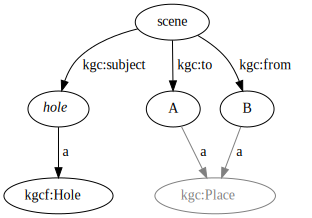

In [8]:
dot = '''
digraph {
  hole [label=<<I>hole</I>>]
  hole_class [label=<kgcf:Hole>]
  hole -> hole_class [label=<  a>]
  place_class  [label=<  kgc:Place>, color=gray, fontcolor=gray]
  // object_class [label=<  kgc:Object>, color=gray, fontcolor=gray]
  scene -> hole [label=<  kgc:subject>];
  scene -> A [label=<  kgc:to>]
  A -> place_class [label=<  a>, color=gray]
  // A -> object_class [label=<  a>, color=gray]
  scene -> B [label=<  kgc:from>]
  B -> place_class [label=<  a>, color=gray]
  // B -> object_class [label=<  a>, color=gray]
}
'''
print_dot(dot)

In [9]:
# kgcf:Hole class の sub class 一覧
q = '''
SELECT DISTINCT ?hole_class 
WHERE {
  ?hole_class rdfs:subClassOf* kgcf:Hole .
}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

,hole_class
0,kgcf:Hole
1,kgcf:Ventilator
2,kgcf:Door
3,kgcf:Window
4,kgcf:Chimney


In [10]:
# Hole 系の class のインスタンス一覧
q = '''
SELECT DISTINCT ?hole ?hole_class 
WHERE {
  ?hole_class rdfs:subClassOf* kgcf:Hole .
  ?hole a ?hole_class .
}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

,hole,hole_class
0,kd:hole,kgcf:Hole
1,kd:ventilator,kgcf:Ventilator
2,kd:door,kgcf:Door
3,kd:door_of_bedroom_of_Julia,kgcf:Door
4,kdf:door_of_bedroom_of_Roylott,kgcf:Door
5,kdf:door_of_bedroom_of_Helen,kgcf:Door
6,kd:window,kgcf:Window
7,kd:window_of_bedroom_of_Helen,kgcf:Window
8,kd:window_of_bedroom_of_Roylott,kgcf:Window
9,kd:window_of_left_building_of_mansion_of_Roylott,kgcf:Window


### ルールを作る

In [11]:
rules = dict()

In [12]:
q = '''
SELECT DISTINCT ?x ?y ?hole ?scene
WHERE{

  # ?x と ?y が穴でつながっている
  {
    ?scene rdf:type ?sceneType ;
           kgc:hasPredicate ?predExist ;
           kgc:subject ?hole .
    ?scene kgc:from ?x ;
           kgc:to ?y .
  } UNION {
    ?scene rdf:type ?sceneType ;
           kgc:hasPredicate ?predExist ;
           kgc:subject ?hole .
    ?scene kgc:from ?y ;
           kgc:to ?x .
  } UNION {
    ?scene rdf:type ?sceneType ;
           kgc:hasPredicate ?predExist ;
           kgc:subject ?hole .
    ?scene kgc:where ?x ;
           kgc:where ?y .
  } UNION {
    ?scene rdf:type ?sceneType ;
           kgc:hasPredicate ?predExist ;
           kgc:subject ?hole .
    ?scene kgc:where ?x ;
           kgc:to ?y .
  } UNION {
    ?scene rdf:type ?sceneType ;
           kgc:hasPredicate ?predExist ;
           kgc:subject ?hole .
    ?scene kgc:where ?y ;
           kgc:to ?x .
  }

  ?holeType rdfs:subClassOf* kgcf:Hole .
  ?hole a ?holeType . 

  ?x a ?xType .
  ?y a ?yType .  
  
  FILTER(?sceneType in (kgc:Situation, kgc:Thought, kgc:Talk))
  FILTER(?predExist in (kd:go, kd:exist))
  FILTER(?xType in (kgc:Object, kgc:Place))
  FILTER(?yType in (kgc:Object, kgc:Place))
  FILTER(?x != ?y)
} ORDER BY ?scene
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)


rules['main'] = extract_rule(q)

,x,y,hole,scene
0,kd:bedroom_of_Helen,kd:corridor,kd:window_of_bedroom_of_Helen,kd:183
1,kd:corridor,kd:bedroom_of_Helen,kd:window_of_bedroom_of_Helen,kd:183
2,kd:bedroom_of_Julia,kd:corridor,kdf:window_of_bedroom_of_Julia_corridorside,kd:184
3,kd:corridor,kd:bedroom_of_Julia,kdf:window_of_bedroom_of_Julia_corridorside,kd:184
4,kd:bedroom_of_Roylott,kd:corridor,kd:window_of_bedroom_of_Roylott,kd:185
5,kd:corridor,kd:bedroom_of_Roylott,kd:window_of_bedroom_of_Roylott,kd:185
6,kd:bedroom_of_Julia,kd:bedroom_of_Roylott,kd:ventilator,kd:221
7,kd:bedroom_of_Roylott,kd:bedroom_of_Julia,kd:ventilator,kd:221
8,kd:bedroom_of_Julia,kd:bedroom_of_Roylott,kd:hole,kd:276
9,kd:bedroom_of_Roylott,kd:bedroom_of_Julia,kd:hole,kd:276


In [ ]:
q = '''
SELECT ?scene1 
WHERE {
  # 人は ?hole を通れない
  {
    {
      ?scene1 rdf:type ?scenetype2 ;
              kgc:hasPredicate ?prednotgo ;
              kgc:subject kd:man .
      ?scene1 kgc:from ?x ;
              kgc:to ?y .
     } UNION {
       ?scene1 rdf:type ?scenetype2 ;
               kgc:hasPredicate ?prednotgo ;
               kgc:subject kd:man .
       ?scene1 kgc:from ?y ;
               kgc:to ?x .
     }
  } UNION {
     ?scene1 kgc:where ?hole .
  }
  FILTER(?scenetype2 in (kgc:Situation, kgc:Thought, kgc:Talk))
  FILTER(?prednotgo in (kd:cannotGo, kd:notGo))
}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

rules['minus_1'] = extract_rule(q)

In [ ]:
q = '''
# ?hole が通れないような性質をもつ（鍵がかかっている、狭い、閉まっている、小さい）
SELECT ?scene2
WHERE {
  ?scene2 rdf:type ?scenetype3 ;
          kgc:hasProperty ?prop ;
          kgc:subject ?hole .
  FILTER(?scenetype3 in (kgc:Situation, kgc:Thought, kgc:Talk))
  FILTER(?prop in (kd:lock, kd:narrow, kd:close, kd:small, kd:beSmall))
}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

rules['minus_2'] = extract_rule(q)

In [ ]:
q = '''
# 穴が塞がっている（内部に障害物がある）
SELECT DISTINCT ?scene3 
WHERE {
  ?scene3 rdf:type ?scenetype4 .
  {
    ?scene3 kgc:hasPredicate kd:exist ;
            kgc:where ?hole ;
            kgc:subject ?obstacle .
  } UNION {
    ?scene3 kgc:hasPredicate kd:have ;
            kgc:subject ?hole ;
            kgc:what ?obstacle .
  }
  ?obstacle rdf:type kgc:Object .
  FILTER(?scenetype4 in (kgc:Situation, kgc:Thought, kgc:Talk))
}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

rules['minus_3'] = extract_rule(q)

### ルールをまとめる

In [16]:
q = f'''
SELECT ?x ?y ?hole ?scene {{
  {rules['main']}
  
  MINUS {{
    {rules['minus_1']}
  }}
  
  MINUS {{
    {rules['minus_2']}
  }}
  
  MINUS {{
    {rules['minus_3']}
  }}
}}
'''
res = g.query(q)
pretty_print(res, g.namespace_manager)

,x,y,hole,scene
0,kd:bedroom_of_Roylott,kd:corridor,kdf:door_of_bedroom_of_Roylott,kd:48
1,kd:bedroom_of_Helen,kd:corridor,kdf:door_of_bedroom_of_Helen,kd:50
2,kd:corridor,kd:bedroom_of_Roylott,kdf:door_of_bedroom_of_Roylott,kd:48
3,kd:corridor,kd:bedroom_of_Helen,kdf:door_of_bedroom_of_Helen,kd:50
4,kd:bedroom_of_Roylott,kd:corridor,kdf:door_of_bedroom_of_Roylott,kd:48
5,kd:bedroom_of_Helen,kd:corridor,kdf:door_of_bedroom_of_Helen,kd:50
6,kd:corridor,kd:bedroom_of_Roylott,kdf:door_of_bedroom_of_Roylott,kd:48
7,kd:corridor,kd:bedroom_of_Helen,kdf:door_of_bedroom_of_Helen,kd:50


### 移動できた場所の情報を追加

移動可能な場所の情報を追加

In [17]:
prefixes = dict(g.namespaces())
have_open_hole_to = prefixes['kdf'] + 'haveOpenHoleTo'
triples = []
for b in res.bindings:
  triples.append((b['x'], have_open_hole_to, b['y']))
  triples.append((b['y'], have_open_hole_to, b['x']))
g = insert(g, triples)

### 移動できた場所を検索

In [19]:
q = '''
SELECT distinct ?start ?goal 
WHERE { 
  ?start kdf:haveOpenHoleTo+ ?goal . 
  FILTER(?start != ?goal)
}
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

,start,goal
0,kd:bedroom_of_Roylott,kd:corridor
1,kd:bedroom_of_Roylott,kd:bedroom_of_Helen
2,kd:bedroom_of_Helen,kd:corridor
3,kd:bedroom_of_Helen,kd:bedroom_of_Roylott
4,kd:corridor,kd:bedroom_of_Roylott
5,kd:corridor,kd:bedroom_of_Helen


### 事件当時，各々の居場所から ジュリアの寝室に移動できたか検索

In [20]:
q = '''
SELECT distinct ?subject ?start ?goal 
WHERE { 
  BIND(kd:67 as ?muder_scene) # 殺人のシーン
  ?muder_scene kgc:when ?the_time.
  
  ?subject a kgc:Person.
  
  ?scene kgc:when ?the_time;
         kgc:subject ?subject;
         kgc:where ?location.
         
  MINUS {
    ?muder_scene kgc:then+ ?scene.
  }
  
  BIND (?location as ?start)
  BIND (kd:bedroom_of_Julia as ?goal)
  ?start kdf:haveOpenHoleTo+ ?goal . 
  FILTER(?start != ?goal)
}
'''


res = g.query(q)
pretty_print(res, g.namespace_manager)

,subject,start,goal
